# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

### Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

The relative population density was also proposed to calculate the global mean values of exposure;

$$
    E(x,t) = \frac{\Delta T(x,t)D(x,t)}{\bar D}
$$

Where $D(x,t) = \tfrac{P(x,t)}{A(x)}$ is the population density at x at time t, and $\bar D$ is the global mean population density. This will result in the same qualitative conclusions as equation 1, but the units have been converted from Kelvin millions of people to Kelvin for the exposure maps.

**NOTE: The aim of this final indicator is to have an axis in Kelvin, and this is probably the most important one. The reason for this is that it makes it easy to have plots of the raw temperature change and the exposure change side by side and demonstrate with comparable axes that there is an important difference between the change in temperature and the change in temperature experienced by people**


### Updates/Clarifications to Method

Aim is to measure 'temperature change experienced by people'. End goal is a value in Kelvin which is the equivalent of the global mean temperature change but weighted by population

We operate on gridded data.

First, just multiply the temperature change by the number of people at each point (x) for a given time (t):

$$
E(x,t) = \Delta T(x,t)P(x)
$$


We want to limit to the temperature change in the summer months for a given year, so first define all operations for a chosen year Y. The flobal $\Delta T(x,t)$ array is calculated by taking the mean temperature change for June, July, August for the northern hemisphere (latitude >= 0) and joining it with the array ofthe mean temperature change for December, January, February for the southern hemisphere (latitude < 0).

This gives a value in Kelvin x Npeople, which isn't hugely intuitive. When we take the global average with therefore divide by the total population for that year, $\sum P(x)$:

$$
\bar{E} = \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)}
$$

This can be repeated for each year to get a time series. However, we'd also like to map the value for each year in a similarly intuitive way. We can do this using the mean population per grid point:

$$
\bar{P} = \sum P(x) / N
$$

And calculating the exposure at each point as the population divided by the mean population:

$$
E(x,t) = \Delta T(x,t)P(x) / \bar{P}
$$

The average of this value over the grid (with number of points N) is equal to the $\bar{E}$:


$$
Mean = \frac{\sum \Delta T(x,t)P(x,t) / \bar{P} }{N} \\
= \frac{\sum \Delta T(x,t)P(x,t) / (\sum P(x) / N) }{N} \\
= \frac{ \tfrac{N}{\sum P(x)} \sum \Delta T(x,t)P(x,t) }{N} \\
= \frac{ N   \sum \Delta T(x,t)P(x,t) }{N \sum P(x)} \\
= \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)} = \bar{E} 
$$


#### Area weighting

TODO: decide how to treat this.

It may be desired to weight the temperatures by the area of the grid square. Since we care mostly about the temperature change *per person*, population densities are perhaps not the most interesting aspect. The area weighting aims to accound for the differing size of *temperature* grid squares at the poles - so we would want to premultiply the temperature differences to account for this.

Note that again, since we care about population, this might not be particularly desirable since the change in area will already be captured by the change in number of people per grid unit - if the grid unit has a smaller area, there will be less people, so the distribution is 'naturally' wieghted.




#### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt

from affine import Affine

import weather_ecmwf
import population_tools

from config import (DATA_SRC, ERA_MONTHLY_FILE, 
                    CLIMATOLOGY_FILE_MONTHLY, POP_DATA_SRC)


# Load weather

In [2]:
era_weather = weather_ecmwf.weather_dataset(ERA_MONTHLY_FILE)
era_weather = era_weather.sel(time=slice('2000','2016'))

In [3]:
era_climatology = weather_ecmwf.climatology_dataset(CLIMATOLOGY_FILE_MONTHLY)

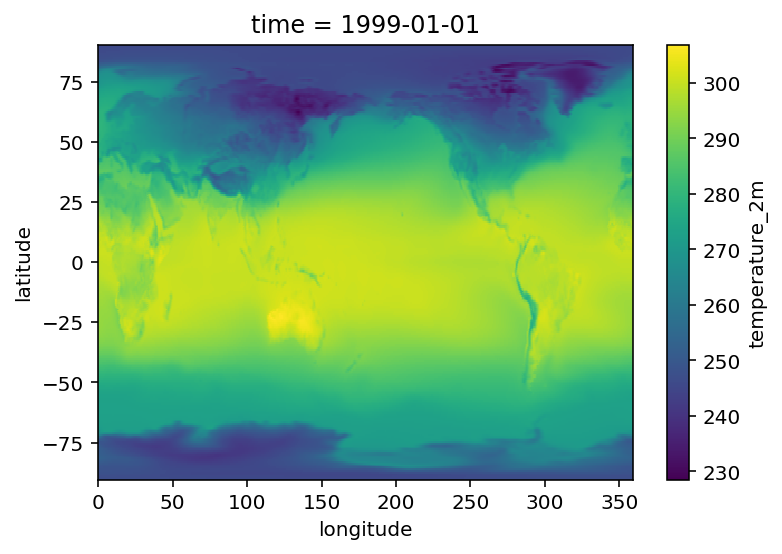

In [4]:
era_climatology.temperature_2m.sel(time='1999-01-01').plot()

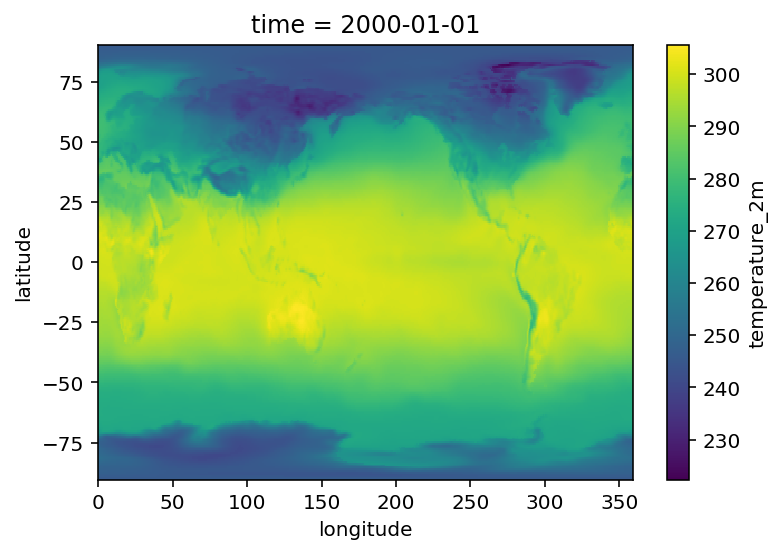

In [5]:
era_weather.temperature_2m.sel(time='2000-01-01').plot()

## Get ∆T for each month of each year

- Group by time.year and apply subtraction for each month

In [6]:
clim_t = era_climatology.temperature_2m

def sub_months(era_t_yr):
    """Swap in the time axis so the datasets auto-align
    """
    clim_t['time'] = era_t_yr.time
    return era_t_yr - clim_t
    
delta_t = era_weather.temperature_2m.groupby('time.year').apply(sub_months)


## Get the mean delta for each summer

In [7]:
def collect_summer_delta(delta_t):
    """Wrap in a function to clear temporary vars from memory"""
    # northern hemisphere
    lat_north = delta_t.latitude[delta_t.latitude >= 0]
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf).groupby('time.year').mean(dim='time')

    summer_anom = xr.concat([nh.sel(latitude=lat_north),  
                             sh.sel(latitude=lat_south)], dim='latitude')
    return summer_anom

summer_anom = collect_summer_delta(delta_t)

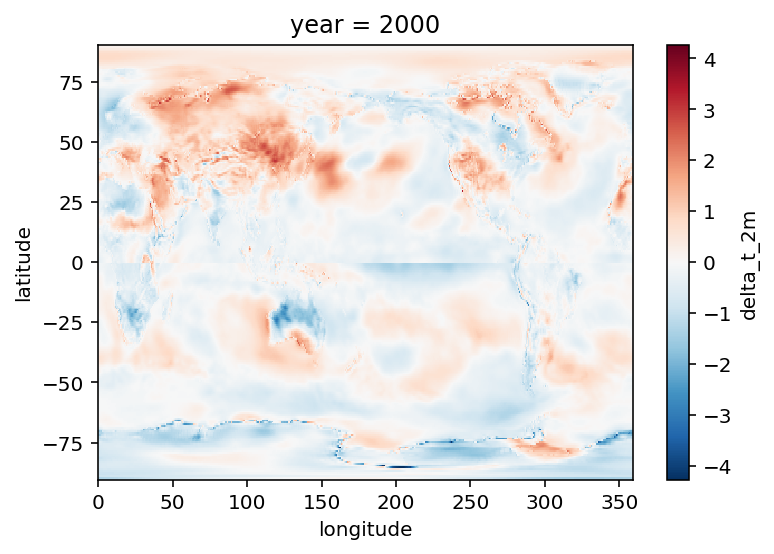

In [8]:
summer_anom.sel(year=2000).plot()

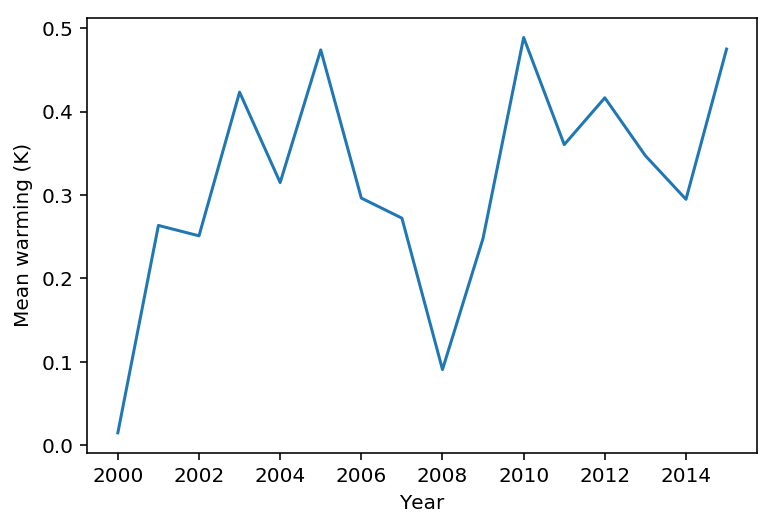

In [7]:
summer_anom.sel(year=slice('2000','2015')).mean(dim=['latitude', 'longitude']).plot()
plt.xlabel('Year')
plt.ylabel('Mean warming (K)')

plt.savefig('mean_warming_2000-2015.png', dpi=300)


## Project to total population

In [36]:
from importlib import reload
reload(population_tools)

<module 'population_tools' from '/Users/jonathanchambers/Documents/UCL/Lancet/health-climate-exposure/population_tools.py'>

In [44]:
years = list(range(2000, 2016))

with population_tools.PopulationProjector('population_count_2000-2020.nc', mask_empty=True) as pop:
    summer_exposures = []
    pop_sum = []
    pop_mean = []
    for year in years:
        print(year)
        pop_year = pop.data.population.sel(time=f'{year}')
        pop_sum.append(pop_year.sum(dim=['latitude', 'longitude']))
        pop_mean.append(pop_year.mean(dim=['latitude', 'longitude']))

        summer_exposures.append(pop.project(year, summer_anom.sel(year=year)))
        
    summer_exposures = xr.concat(summer_exposures, dim='time')
    pop_sum = xr.concat(pop_sum, dim='time')
    pop_mean = xr.concat(pop_mean, dim='time')
    summer_exposures_ts = (summer_exposures / pop_sum).sum(dim=['latitude', 'longitude']).compute()
    summer_exposures = (summer_exposures / pop_mean).compute()
    
#     pop_mean = pop_mean.compute()

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)


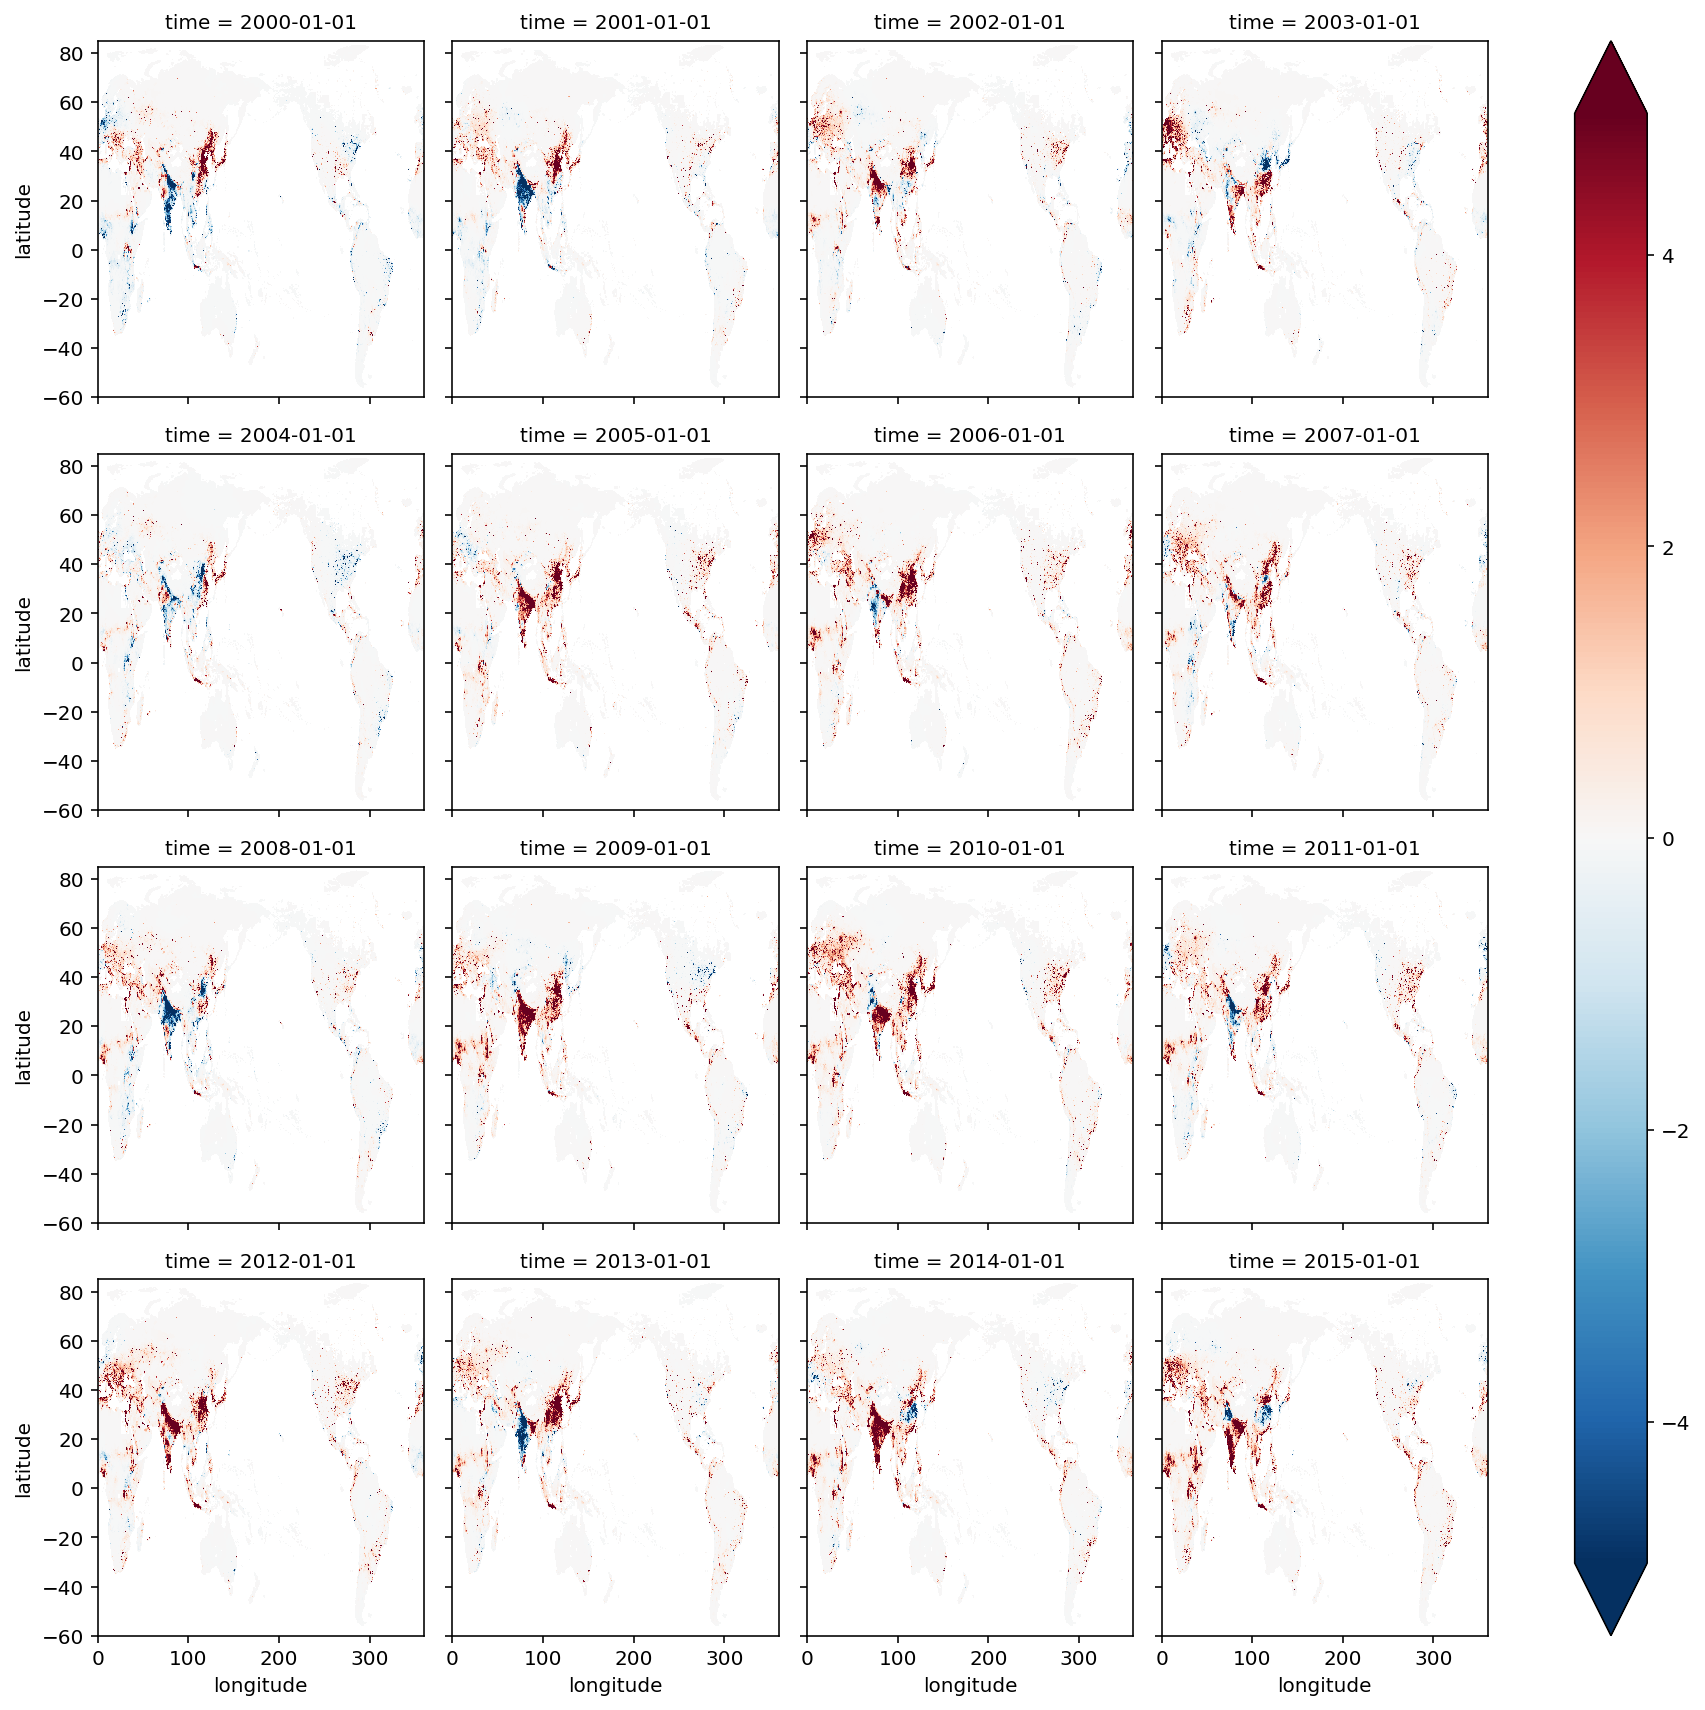

In [48]:
# TODO roll the axes to get longitude -180 to 180 for nicer plotting.
# summer_exposures = np.roll(summer_exposures, summer_exposures.shape[1]//2, axis=1)
# summer_exposures['longitude'] = summer_exposures['longitude'] - 180


summer_exposures.plot(robust=True,  col='time', col_wrap=4)

In [51]:
summer_exposures.name = 'summer_exposure'
summer_exposures.to_netcdf(str(DATA_SRC /'lancet' / 'summer_exposure.nc'))

In [55]:
summer_exposures_ts.name = 'summer_exposure'
summer_exposures_ts.to_netcdf(str(DATA_SRC /'lancet' / 'summer_exposure_ts.nc'))

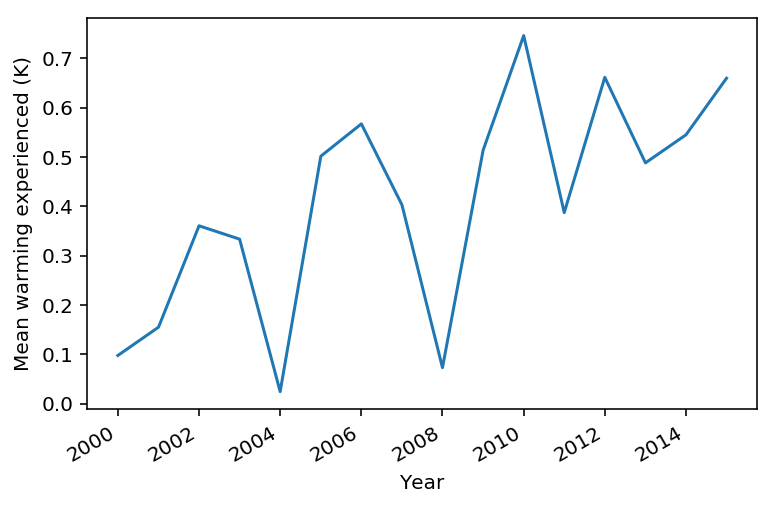

In [50]:
summer_exposures_ts.plot()
plt.xlabel('Year')
plt.ylabel('Mean warming experienced (K)')
plt.savefig('mean_warming_experienced_2000-2015.png', dpi=300)



## Project to population density

In [52]:
# years = list(range(2000, 2016))

# with population_tools.PopulationProjector('population_density_2000-2020.nc', 
#                                             mask_empty=True) as pop:
#     summer_exposures_dns = []
#     pop_density_mean = []
        
#     for year in years:
#         print(year)
#         pop_year = pop.data_empty_masked.population.sel(time=f'{year}')
        
#         mean_density = pop_year.mean(dim=['latitude', 'longitude'])
#         pop_density_mean.append(mean_density)

#         t_anom_by_density = pop.project(year, summer_anom.delta_t_2m.sel(year=year))
#         t_anom_by_density = t_anom_by_density / mean_density
# #         t_anom_by_density['time'] = t_anom_by_density['time.year']
#         summer_exposures_dns.append(t_anom_by_density)

# summer_exposures_dns = xr.concat(summer_exposures_dns, dim='time')
# summer_exposures_dns['time'] = summer_exposures_dns['time.year']
# pop_density_mean = xr.concat(pop_density_mean, dim='time')

In [25]:
summer_exposure_out_file = DATA_SRC / 'lancet' / 'summer_exposure_density.nc'

In [26]:
summer_exposures_dns.name = 'summer_exposure_density'
summer_exposures_dns.to_netcdf(str(summer_exposure_out_file))

In [50]:
summer_exposures_dns = xr.open_dataarray(str(summer_exposure_out_file))

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


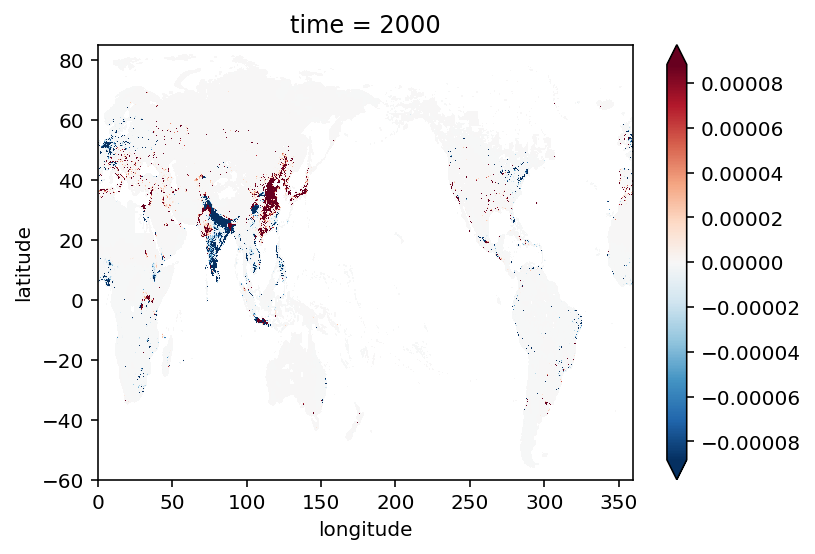

In [72]:
summer_exposures_dns.sel(time=2000).plot(robust=True)

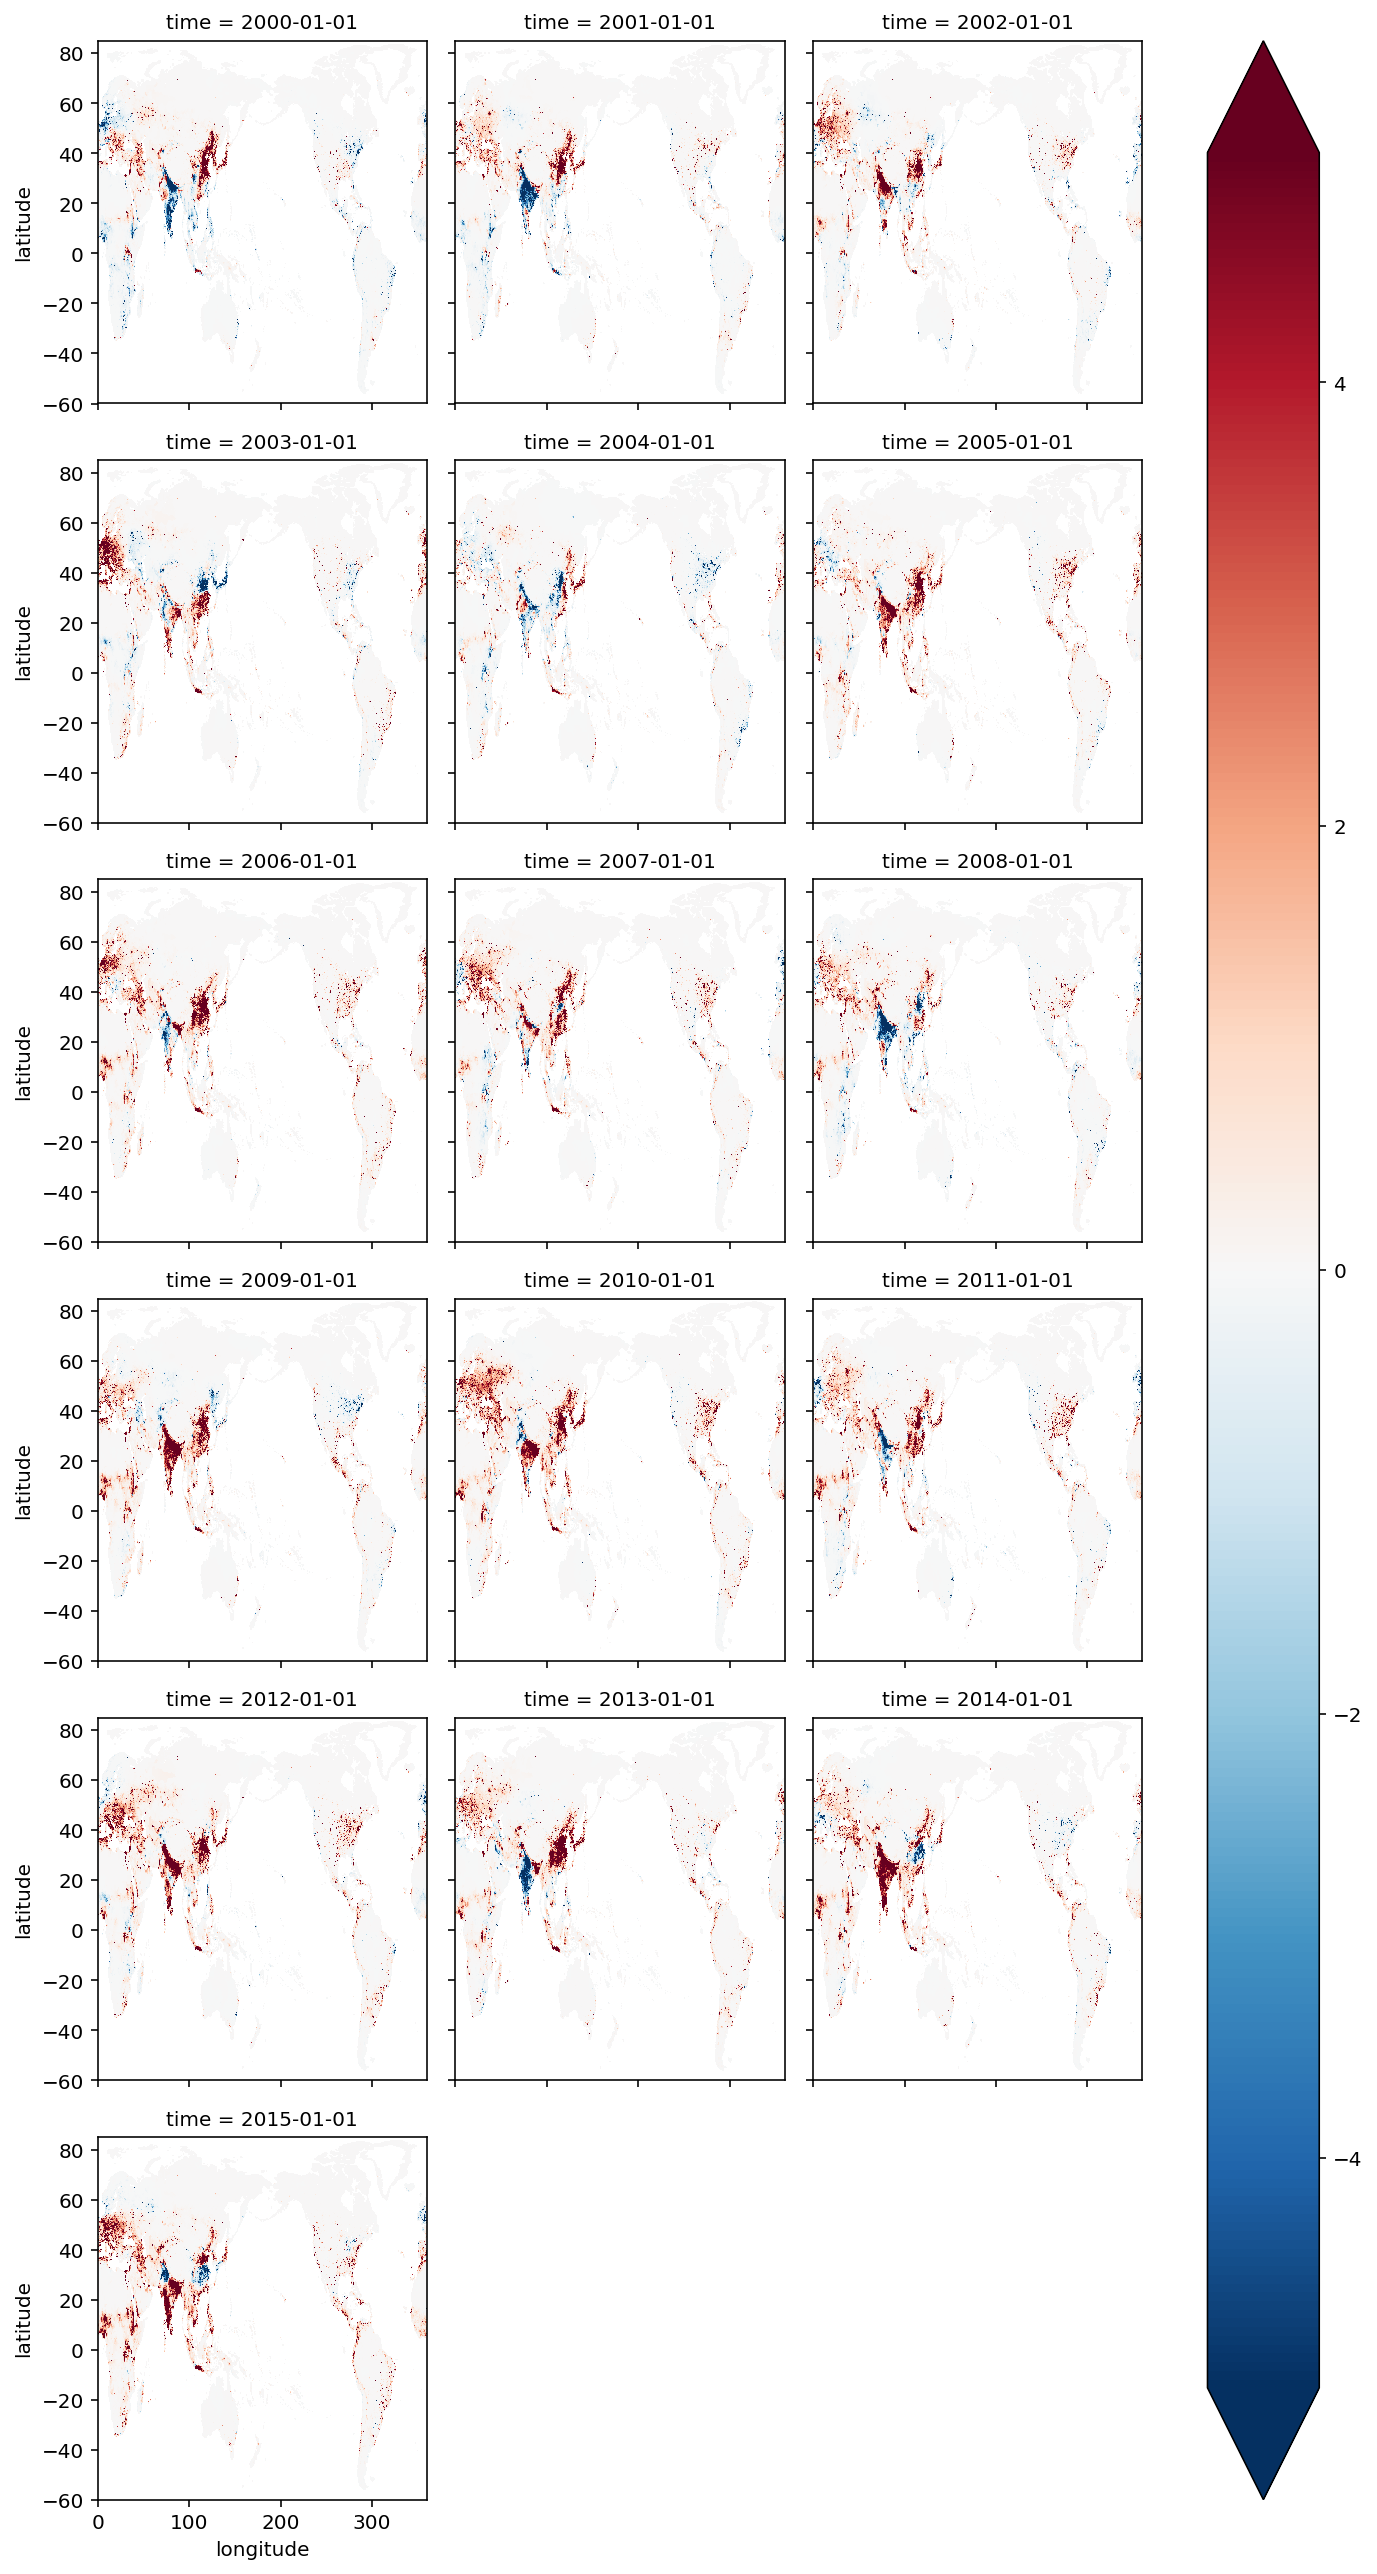

In [144]:
summer_exposures_dns.plot(robust=True,  col='time', col_wrap=4)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


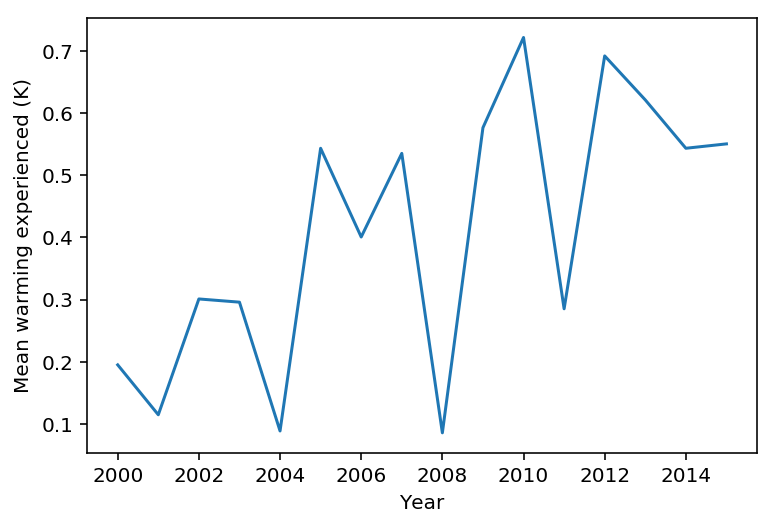

In [76]:
summer_exposures_dns.mean(dim=['latitude', 'longitude']).plot()
plt.xlabel('Year')
plt.ylabel('Mean warming experienced (K)')


In [18]:
# Wrangle to geotiff for easy viewing

# pop_crs, pop_affine = population_tools.get_crs_and_affine()

# exposure = exposure.values
# exposure.shape = (exposure.shape[0], exposure.shape[1])
# exposure = np.roll(exposure, exposure.shape[1]//2, axis=1)


# with rasterio.open(str(DATA_SRC / 'lancet' / f'dt_exposure_mean_{year}.tif'),
#                    'w',
#                    driver='GTiff',
#                    height=height,
#                    width=width,
#                    count=1,
#                    dtype=exposure.dtype,
#                    crs=pop_crs,
#                    transform=pop_affine,
#                    compress='lzw') as new_dataset:
#     new_dataset.write(exposure, 1)